<a href="https://colab.research.google.com/github/Mokshith1708/FoodVision_CV/blob/main/project1_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ee0f3eca-3044-a253-f8bd-1539f52a2a9f)


## Getting helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-17 16:27:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-17 16:27:38 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



##Importing series of helper functions

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Using TensorFlow datasets

In [ ]:
import tensorflow_datasets as tfds
datasets_lists = tfds.list_builders()
print("food101" in datasets_lists)

True


##Loading data

In [16]:
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns

In [17]:
#Features of dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [18]:
#Getting Class Names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [19]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [20]:
#taking one sample of Train_data
train_one_sample  = train_data.take(1)

In [21]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [22]:
#Info about our training data
for image, label in train_one_sample:
  print(f"""
  image shape: {image.shape}
  image datatype: {image.dtype}
  Target class from Food101(tensor form): {label}
  class name (str form): {class_names[label.numpy()]}
        """)


  image shape: (512, 512, 3)
  image datatype: <dtype: 'uint8'>
  Target class from Food101(tensor form): 43
  class name (str form): fried_calamari
        


In [23]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

In [24]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

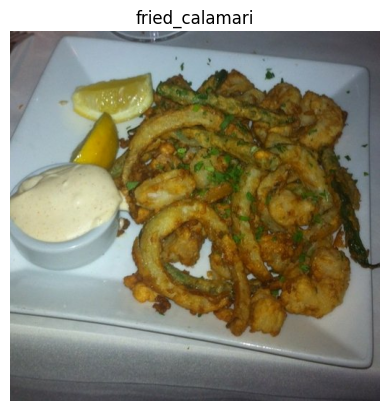

In [25]:
#PLot an image of tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Creating preprocessing functions for our data

In [26]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image)

In [27]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.81122   54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

In [28]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbacks


In [30]:
# importing callbacks
from helper_functions import create_tensorboard_callback

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

##Setting mixed precision training


In [31]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [32]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [34]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [35]:
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [36]:
#fit the model
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data = test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnet0_101"),
                                                        model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet0_101/20240617-164256
Epoch 1/3
2368/2368 [==============================] - 218s 85ms/step - loss: 1.7161 - accuracy: 0.5825 - val_loss: 1.1246 - val_accuracy: 0.6968
Epoch 2/3
2368/2368 [==============================] - 189s 78ms/step - loss: 1.1994 - accuracy: 0.6890 - val_loss: 1.0195 - val_accuracy: 0.7219
Epoch 3/3
2368/2368 [==============================] - 172s 72ms/step - loss: 1.0532 - accuracy: 0.7246 - val_loss: 0.9987 - val_accuracy: 0.7264


In [37]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 52s 66ms/step - loss: 0.9965 - accuracy: 0.7283


[0.9965096712112427, 0.7283168435096741]

In [41]:
def create_model():

  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model


In [43]:
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

created_model.load_weights(checkpoint_path)

results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 53s 63ms/step - loss: 0.9965 - accuracy: 0.7283


In [54]:
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all()

In [55]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
save_dir = "/content/drive/MyDrive/models_deep_learning_foodVision"
model.save(save_dir)

In [58]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/foodVision_feature_extraction_model")
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [59]:
results_after_loading = loaded_model.evaluate(test_data)
results_after_loading

790/790 [==============================] - 53s 63ms/step - loss: 0.9965 - accuracy: 0.7283


[0.9965096116065979, 0.7283168435096741]

In [64]:
for layer in loaded_model.layers:
  print(layer.name,layer.trainable)
  layer.trainable = True
  print(layer.name,layer.trainable)

input_layer True
input_layer True
efficientnetb0 False
efficientnetb0 True
pooling_layer True
pooling_layer True
dense True
dense True
softmax_float32 True
softmax_float32 True


In [78]:
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype_policy)


input_1 True <Policy "float32">
rescaling True <Policy "mixed_float16">
normalization True <Policy "mixed_float16">
rescaling_1 True <Policy "mixed_float16">
stem_conv_pad True <Policy "mixed_float16">
stem_conv True <Policy "mixed_float16">
stem_bn True <Policy "mixed_float16">
stem_activation True <Policy "mixed_float16">
block1a_dwconv True <Policy "mixed_float16">
block1a_bn True <Policy "mixed_float16">
block1a_activation True <Policy "mixed_float16">
block1a_se_squeeze True <Policy "mixed_float16">
block1a_se_reshape True <Policy "mixed_float16">
block1a_se_reduce True <Policy "mixed_float16">
block1a_se_expand True <Policy "mixed_float16">
block1a_se_excite True <Policy "mixed_float16">
block1a_project_conv True <Policy "mixed_float16">
block1a_project_bn True <Policy "mixed_float16">
block2a_expand_conv True <Policy "mixed_float16">
block2a_expand_bn True <Policy "mixed_float16">


In [79]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=5)
checkpoint_path="/content/drive/MyDrive/fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor="val_loss")

In [82]:
#learning rate callback
reduce_learningRate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                           factor=0.2,
                                                           patience=2,
                                                            verbose=1,
                                                           min_lr=1e-7)

In [83]:
loaded_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

In [85]:
history_after_fineTuning = loaded_model.fit(train_data,
                                            epochs=10,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)),
                                            callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"),
                                                        model_checkpoint,
                                                        early_stop,
                                                        reduce_learningRate])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20240617-175451
Epoch 1/10
2368/2368 [==============================] - 450s 169ms/step - loss: 0.8679 - accuracy: 0.7666 - val_loss: 0.7484 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 2/10
2368/2368 [==============================] - 409s 171ms/step - loss: 0.5365 - accuracy: 0.8513 - val_loss: 0.7433 - val_accuracy: 0.7961 - lr: 1.0000e-04
Epoch 3/10
2368/2368 [==============================] - 373s 156ms/step - loss: 0.3030 - accuracy: 0.9131 - val_loss: 0.8683 - val_accuracy: 0.7752 - lr: 1.0000e-04
Epoch 4/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9532
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 372s 156ms/step - loss: 0.1575 - accuracy: 0.9532 - val_loss: 0.9337 - val_accuracy: 0.7910 - lr: 1.0000e-04
Epoch 5/10
2368/2368 [==============================] - 388s 162ms/s

In [88]:
results_final = loaded_model.evaluate(test_data)
results_final

790/790 [==============================] - 54s 69ms/step - loss: 1.2367 - accuracy: 0.8071


[1.2367267608642578, 0.8071287274360657]

In [89]:
save_dir = "/content/drive/MyDrive/foodVision_final_model_1"
loaded_model.save(save_dir)

In [90]:
# Assuming you have a trained Keras model named 'model'
weights = loaded_model.get_weights()

# If you want to see the weights of each layer:
for layer in loaded_model.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name}")
    for weight in weights:
        print(weight)


Streaming output truncated to the last 5000 lines.
 1.3644559  1.5358955  1.3071083  0.7149279  1.1500962  0.99834746
 1.0441201  0.6913943  1.1297196  1.6050012  1.3880538  1.8842974
 1.1618882  1.5502794  1.6070297  0.24055639 0.24390234 1.1814406
 0.6938077  1.125235   0.90715486 1.9992261  1.5819513  0.7548212
 1.2489086  1.5052881  1.8635961  0.6386579  1.3268162  0.75567204
 1.3023392  1.3083812  1.1652409  2.0864108  0.8720932  1.5368342
 1.0785903  1.2550449  1.3413584  0.8011348  1.4360536  1.0215362
 1.3361996  0.22878933 1.5927385  1.1607827  1.1354251  0.25069416
 1.2356546  0.6048277  1.2203449  1.2451727  1.3634483  1.5188613
 0.6691465  1.2662507  0.1445932  0.66411704 0.876669   0.98958457
 1.0663394  0.8410166  0.5219677  1.3317813  0.792527   1.1522902
 1.2366556  0.4453664  1.5795885  1.8248073  2.2349427  1.4833405
 0.8399791  0.71163595 1.1466165  0.44544068 0.16088682 0.17788194
 0.5645814  1.0321946  0.8837333  0.83942145 1.3287559  1.0314718
 0.51149935 1.043089